In [46]:
import pymongo
import os
from pprint import pprint
import nytimes
import urllib, json, csv
from datetime import *
from dateutil.relativedelta import *
import calendar, time
from random import randint
from time import sleep
import pandas as pd
from numpy.random import randn
from pandas import Series, DataFrame
import matplotlib as plt
import seaborn as sns
import re
import numpy as np


from __future__ import print_function
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
import statsmodels.api as sm

%matplotlib inline

In [616]:
def nb_name_formatter(path):
    '''creates a formatted list of borough names'''
    names = []
    with open(path, 'rU') as f:
        data = [row for row in csv.reader(f.read().splitlines())]
        for row in data:
            row = row
            names.extend(row)
        return names

def names_no_space(names,code):
        for i, n in enumerate(names):
            names[i-1] = n.replace(' ','')
        return names


#f_path ='/Users/gfsoileau/Metis/Fletcher/bronx_names.csv'

bx_names = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bronx_names.csv')
# bx_no_space = names_no_space(bx_names,'BX')
qn_names = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/queens_names.csv')
# qn_no_space = names_no_space(qn_names,'QN')
mn_names = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/manh_names.csv')
# mn_no_space = names_no_space(mn_names,'MN')
bk_names = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bk_names.csv')
# bk_no_space = names_no_space(bk_names,'BK')
# si_names = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/si_names.csv')
# si_no_space = names_no_space(si_names,'SI')


In [302]:
print(bk_names)

['Bay Ridge', 'Fort Hamilton', 'Bedford-Stuyvesant', 'Ocean Hill', 'Stuyvesant Heights', 'Bensonhurst', 'Bergen Beach', 'Boerum Hill', 'Borough Park', 'Mapleton', 'Brighton Beach', 'Brooklyn Heights', 'Brownsville', 'Bushwick', 'Canarsie', 'Carroll Gardens', 'Clinton Hill', 'Cobble Hill', 'Columbia St Waterfront District', 'Coney Island', 'Crown Heights', 'Weeksville', 'DUMBO', 'Vinegar Hill', 'Ditmas Park', 'Fiske Terrace', 'Downtown Brooklyn', 'Dyker Heights', 'East New York', 'City Line', 'New Lots', 'Flatbush', 'Flatlands', 'Fort Greene', 'Gerritsen Beach', 'Gowanus', 'Gravesend', 'Greenpoint', 'Greenwood', 'Kensington', 'Manhattan Beach', 'Marine Park', 'Midwood', 'Mill Basin', 'Northeast Flatbush', 'Farragut', 'Wingate', 'Ocean Parkway', 'Old Mill Basin', 'Park Slope', 'Prospect Heights', 'Prospect Lefferts Gardens', 'Prospect Park South', 'Red Hook', 'Seagate', 'Sheepshead Bay', 'Homecrest', 'Madison', 'Starrett City', 'Sunset Park', 'Williamsburg', 'East Williamsburg']


redo: bk_bedsty,

In [3]:
years = [2015,2014,2013,2012,2011,2010,2009,2008,2007]

BK_names = ['Bay Ridge','Bedford-Stuyvesant','Bensonhurst','Bergen Beach','Boerum Hill','Borough Park','Brighton Beach',
           'Brooklyn Heights','Brooklyn Navy Yard','Brownsville','Bushwick','Canarsie','Carroll Gardens',
           'Clinton Hill','Cobble Hill','Coney Island','Crown Heights',
           'Cypress Hills','Ditmas Park','Downtown Brooklyn','DUMBO','Dyker Heights','East New York',
           'East Williamsburg','Farragut','Flatbush','Flatlands','Fort Greene','Fort Hamilton','Gerritsen Beach',
           'Gowanus','Gravesend','Greenpoint','Greenwood Heights','Kensington',
           'Manhattan Beach','Marine Park','Midwood','Mill Basin','New Lots','New Utrecht',
           'Ocean Parkway','Old Mill Basin','Park Slope','Prospect Heights',
           'Prospect Lefferts Gardens','Prospect Park South','Red Hook','Seagate','Sheepshead Bay',
           'Stuyvesant Heights','Sunset Park','Vinegar Hill','White Sands','Williamsburg','Windsor Terrace']


In [267]:
def nyt_api(names, years):
    '''calls nytimes api with a formatted query string and saves json file '''
    search_obj = nytimes.get_article_search_obj ('7ff048af1779e0c12cf7038c3d9476a0:15:56968285')
    for n in names:
        for y in years:
            search_obj.article_search(filename="'"+n+str(y)+".json" "'",q="'"+n+" real estate" "'",begin_date=str(y)+"0101",end_date=str(y)+"1231")  
            
nyt_api(si_names,years)

In [104]:
def format_nyt_dict(path, borough):
    '''format the json files return from the API and insert into mongodb nytimesdb, neighborhood_data.collection.
        Takes the path to directory where files are stored and the borough name'''
    files = os.listdir(path)
    for f in files:
        year = f[-10:-6]
        name_hood = f[1:-10]
        print year, name_hood
        with open(path+f) as json_file:
            print '*' *20
            data = json_file.read().replace('\n', '')
            times_dict = json.loads(data)
            count = 0
            for i in times_dict['response']['docs']:
                print i
                dic = {}
                if i['news_desk'] == 'RealEstate' or i['news_desk'] == 'Metro'and i["section_name"] != "Great Homes & Destinations":
                    count +=1
                    dic['id'] = i['_id']
                    if i['abstract'] is not None:
                        dic['abstract'] = i['abstract'].encode("utf8")
                    dic['headline'] = i['headline']['main'].encode("utf8")
                    dic['desk'] = i['news_desk']
                    dic['date'] = i['pub_date'][0:10] # cutting time of day.
                    dic['section'] = i['section_name']
                    if i['snippet'] is not None:
                        dic['snippet'] = i['snippet'].encode("utf8")
                    dic['source'] = i['source']
                    dic['url'] = i['web_url']
                    dic['word_count'] = i['word_count']
                    dic['neighborhood'] = name_hood
                    dic['year'] = year
                    dic['borough'] = borough
                    dic['count'] = count 
                else:
                    continue
                print dic
                nb.insert(dic)
                
# path = '/Users/gfsoileau/Metis/Fletcher/times_data/qn/'
# format_nyt_dict(path,'QN')

In [40]:
try:
    conn=pymongo.MongoClient()
    print("Connected successfully!!!")
except pymongo.errors.ConnectionFailure, e:
    print("Could not connect to MongoDB: %s" % e)

Connected successfully!!!


In [6]:
#create ny_times db and alias it to db
db = conn.ny_times
# conn.database_names()

In [42]:
db.collection_names()


[u'google_trends',
 u'google_trends_together',
 u'neighborhood_data',
 u'st_easy',
 u'street_easy',
 u'system.indexes',
 u'test',
 u'test_nytimes']

In [84]:
test = db.test_nytimes


In [ ]:
#can copy one collection into another. Problem, each json was added to a list with a single id in mongo.
#wanted an id for each dict in the json file.
for item in gt.find():
    gtt.insert_many(item['trends'])

In [162]:
#drop neighborhood_data collection
conn.ny_times.drop_collection('neighborhood_data')

In [44]:
#create neighborhood_data collection
gt = db.google_trends

In [41]:
#create alias to collections
db = conn.ny_times
gt = db.google_trends
es = db.street_easy
nb = db.neighborhood_data
es_st = db.st_easy
gtt = db.google_trends_together


In [17]:
test = db.test_collection

In [527]:
list(gtt.find({'borough':'Manhattan','neighborhood':'chelsea'}))

[{u'_id': ObjectId('558195b65182c3b7f8e156b8'),
  u'borough': u'Manhattan',
  u'count': u'61',
  u'month': u'01',
  u'neighborhood': u'chelsea',
  u'yr': u'2004'},
 {u'_id': ObjectId('558195b65182c3b7f8e156b9'),
  u'borough': u'Manhattan',
  u'count': u'57',
  u'month': u'01',
  u'neighborhood': u'chelsea',
  u'yr': u'2004'},
 {u'_id': ObjectId('558195b65182c3b7f8e156ba'),
  u'borough': u'Manhattan',
  u'count': u'61',
  u'month': u'01',
  u'neighborhood': u'chelsea',
  u'yr': u'2004'},
 {u'_id': ObjectId('558195b65182c3b7f8e156bb'),
  u'borough': u'Manhattan',
  u'count': u'60',
  u'month': u'01',
  u'neighborhood': u'chelsea',
  u'yr': u'2004'},
 {u'_id': ObjectId('558195b65182c3b7f8e156bc'),
  u'borough': u'Manhattan',
  u'count': u'61',
  u'month': u'02',
  u'neighborhood': u'chelsea',
  u'yr': u'2004'},
 {u'_id': ObjectId('558195b65182c3b7f8e156bd'),
  u'borough': u'Manhattan',
  u'count': u'59',
  u'month': u'02',
  u'neighborhood': u'chelsea',
  u'yr': u'2004'},
 {u'_id': Object

In [42]:
#es.find_one()
#list(es.find())[50:110]
#conn.ny_times.drop_collection('google_trends')

In [520]:
list(es_st.find({'borough':'manhattan','neighborhood':'Chelsea'}))

[{u'_id': ObjectId('5576ef545182c3771efcbd12'),
  u'average_decrease': 867.0,
  u'average_increase': 0.0,
  u'average_ppsf': 1825,
  u'average_price': 2494076,
  u'average_sqft': 1677,
  u'average_wom': 4.636363636363637,
  u'borough': u'manhattan',
  u'criteria': u'status:sold|area:Chelsea-manhattan|listed_between:20150207-20150307',
  u'criteria_description': u'Sale sold listings in Chelsea  listed between 2015-02-07 and 2015-03-07  ',
  u'decrease_count': 1,
  u'increase_count': 0,
  u'listing_count': 13,
  u'median_ppsf': 1660,
  u'median_price': 1565000,
  u'median_sqft': 1234,
  u'median_wom': 4.0,
  u'month': u'02',
  u'neighborhood': u'Chelsea',
  u'percentile_10_price': 685000,
  u'percentile_90_price': 6500000,
  u'search_url': u'http://streeteasy.com/for-sale/chelsea/status:sold%7Clisted_between:20150207-20150307',
  u'sqft_count': 10,
  u'stddev_decrease': 0.0,
  u'stddev_increase': 0.0,
  u'stddev_price': 2283651.240591647,
  u'stddev_sqft': 1207.7311878982932,
  u'stddev_

In [251]:
cursor = nb.find({"neighborhood":"Park Slope", 'year':'2010'})

In [11]:
hood_names = ['Boerum_Hill','Borough_Park','Brighton_Beach',
           'Brooklyn_Heights','Brooklyn_Navy_Yard','Brownsville','Bushwick','Canarsie','Carroll_Gardens',
           'Clinton_Hill','Cobble_Hill','Coney_Island','Crown_Heights',
           'Cypress_Hills','Ditmas_Park','Downtown_Brooklyn','DUMBO','Dyker_Heights','East_New_York',
           'East_Williamsburg','Farragut','Flatbush','Flatlands','Fort_Greene','Fort_Hamilton','Gerritsen_Beach',
           'Gowanus','Gravesend','Greenpoint','Greenwood_Heights','Kensington',
           'Manhattan_Beach','Marine_Park','Midwood','Mill_Basin','New_Lots','New_Utrecht',
           'Ocean_Parkway','Old_Mill_Basin','Park_Slope','Prospect_Heights',
           'Prospect_Lefferts_Gardens','Prospect_Park_South','Red_Hook','Seagate','Sheepshead_Bay',
           'Stuyvesant_Heights','Sunset_Park','Vinegar_Hill','White_Sands','Williamsburg','Windsor_Terrace']
#'Bay_Ridge','Bedford_Stuyvesant','Bensonhurst','Bergen_Beach'(notfinished)

In [102]:
api_keys = ['ff70b20c1c4e0a4b0fcbd45a4a97dcd0fceebdc3','2a0c1d73b28f373a660de59f408471967c9bfd91',
            'dc87c720b13afec5f010dffe7d3ee6aac0539ef4','bd9f608751bdad74e946d4dba73e309d4b05894b',
            '14d0372671c71f144d24699998a0670482238f5c','71addf314166bb097a6bb4d81c75680c6048da15',
            '2d2fb018b6a1d485efcc0be4f2456edec6d0d9ec','107e6df6dd9d259cb7edd2408246920817f643ca',
            '6bfd4448e5a38a9d7dbd2555e7663d7bfde315b1','8670b57035a194e0772b3ff0b47669567ed895d0']

def format_hoods(hood_list):
    '''remove all spaces in BK neighborhood names, not needed for other neighborhoods'''
    formatted_hoods = []
    for h in hood_list:
        formatted_h = h.replace(' ','')
        formatted_hoods.append(formatted_h)
    return formatted_hoods 
# formatted_hoods = format_hoods(q_terms)
# print formatted_hoods

def get_street_easy(neighborhoods,keys, borough):
        '''loops through neighborhood list and collects aggregated sales data for the prior 97 months from streeteasy.com
        The year, month and borough are added to each json. The jsons are stored in the street_easy collection'''
        count =1
        api_counter = 0
        for n in neighborhoods:
            today = date.today()
            today = today+relativedelta(months = -3,days = -2)
            for i in range(1,97):
                if count <= 97 and api_counter <= 9: 
                    start_month = today
                    end_month = today+relativedelta(months=-1)
                    end_dt = str(start_month).replace('-','')
                    start_dt = str(end_month).replace('-','')
                    today = end_month
                    year = start_dt[0:4]
                    month = start_dt[4:6]                 
                    #print count, 'http://streeteasy.com=area:'+h+'-brooklyn|status:sold%7Clisted_between:'+start_dt+'-'+end_dt+'key='+keys[api_counter]
                    #count += 1
                    url = 'http://streeteasy.com/nyc/api/sales/data?criteria=area:'+n+'-bronx|status:sold%7Clisted_between:'+start_dt+'-'+end_dt+'&key='+keys[api_counter]+'&format=json'
                    count += 1
                    try:
                        response = urllib.urlopen(url);
                        data = json.loads(response.read())
                        data['borough'] = borough
                        data['year'] = year
                        data['month'] = month
                        data['neighborhood'] = n
                        st_e.insert(data)
                        print count, url, data
                        time.sleep(5)
                    except:
                        print "Could not get json: %s" % e, url
                else:
                    if api_counter < 9:
                        api_counter += 1
                        count = 0
                        print '*************************change key*************************************'
                    else:
                        print '**************************sleep and restart*****************************'
                        #time.sleep(500) 
                        api_counter = 0
                        count = 0
                
                            
# get_street_easy(bx_no_space,api_keys,'Bronx')    

In [26]:
def gt_formatter(path, borough):
    '''parses gtrends csv files into a python dictionary '''
    print("hello")
    files = os.listdir(path)
    borough2 = ""
    if borough == 'bk':
        borough2 = 'Brooklyn'
    elif borough == 'bx':
        borough2 = 'Bronx'
    elif borough == 'qn':
        borough2 = 'Queens'
    elif borough == 'si':
        borough2 = 'Staten Island'
    else : #borough == 'mn':
        borough2 = "Manhattan"
        
    for i in files:
        gt_dict = {}
        with open('/Users/gfsoileau/Metis/Fletcher/google_trends/'+borough+'/'+i, 'rU') as f:
            gt_list = []
            gt_dict = {}
            data = [row for row in csv.reader(f)]
            header = ''.join(data[0])
            header = header.split(':')
            header1 = header[1]
            header1 = header1.split('neighborhood')
            header1 = header1[0].strip()
            
            for row in data[5:]:
                if len(row) < 1:
                    break
                dic = {}
                yr = row[0]
                yr = yr.split('-')
                dic['count'] = row[1]
                dic['borough'] = borough2
                dic['neighborhood'] = header1
                dic['date'] = yr[0]+'-'+yr[1]+'-01'
                gt_list.append(dic)

#             for row in data[5:]:
#                 if len(row) < 1:
#                     break
#                 dic = {}
#                 yr = row[0]
#                 yr = yr.split('-')
#                 month = 'none'
#                 m_ct = 0
#                 dic['yr'] = yr[0]
#                 dic['month'] = yr[1]
#                 dic['count'] = row[2]
#                 dic['borough'] = borough2
#                 dic['neighborhood'] = header1
#                 gt_list.append(dic)


                
#         gt_dict['trends'] = gt_list 
#         gt.insert(gt_dict)   
#         pprint(gt_dict)
                
# path ='/Users/gfsoileau/Metis/Fletcher/google_trends/bx/test'
# gt_formatter(path,'bx')

hello


Error: line contains NULL byte

In [29]:
def convert(name):
    s1 = re.sub('(.)([A-Z][a-z]+-)', r'\1 \2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1 \2', s1).lower()

In [31]:
print(convert('Bedford-Sty'))

bedford-sty


In [32]:
def nyt_format_hood(borough, neighborhood):
        '''formatt neighborhood parameter for query. For NYT, capitalize first letter of each name and 
        keep spaces: 'East Village', borough has first letter capitalized. Called from data function'''
        borough = borough[0].upper()+borough[1:]
        nb = []
        if neighborhood == 'all':
            if borough == 'Brooklyn':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bk_names.csv')
            elif borough == 'Bronx':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bronx_names.csv')
            elif borough == 'Manhattan':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/manh_names.csv')
            elif borough == 'Staten island':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/si_names.csv')
            else:
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/queens_names.csv')
        else:
            nb.append(neighborhood)
        return nb  

def nyt_data(borough, neighborhood):
    '''creates a list of dictionaries of total ny_times hits per year for a neighborhood. '''
    articles = []
    borough = borough[0].upper()+borough[1:]
    years = ['2007','2008','2009','2010', '2011', '2012','2013','2014','2015']
    for n in neighborhood:
        for y in years:
            cursor = nb.find({'neighborhood':n,'borough':borough, 'year':y}, {'_id':True,'borough':borough, 'neighborhood':n,'month':1, 'year':1,'date':1})
            for i in cursor:
                articles.append(i)
    df = DataFrame(articles)
    df['date'] = df['year'] + '-' + df['month'] + '-01'
    df['counts'] = 1
    
    for n in df['neighborhood']:
        df['neighborhood'] = n.lower()
        
    return df

# hoods = nyt_formatt_hood('Bronx', 'City Island')
# prob = nyt_data('Bronx', hoods)

In [497]:

def esy_query(p1, p2, borough, neighborhood):
    '''calls mongodb with query. Called by data function'''
    borough = borough.lower()
    for n in neighborhood:
        cursor = es_st.find({'neighborhood':n, 'borough':borough, 'median_price':{'$gt':p1,'$lt':p2}}, {'borough':borough, 'neighborhood':n,'_id':True, 'median_price':1,'year':1,'month':1})
        results = list(cursor)
#     print(results)
    if not results:
        return None
    df = DataFrame(results)
    df['date'] = df.year +'-' + df.month + '-01'
    
    for n in df['neighborhood']:
        spaces = convert(n)
        df['neighborhood'] = spaces
        
    for b in df['borough']:
        b = b[0].upper() + b[1:]
        df['borough'] = b
    
    return df

def esy_format_hood(borough, neighborhood):
        '''formatt neighborhood parameter for query. For mongo, capitalize first letter of each name but 
        remove spaces: East Village. Called from data function'''
        nb = []
        if neighborhood == 'all':
            if borough == 'Brooklyn':
                nb = names_no_space(nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bk_names.csv'),'BK')
            elif borough == 'Bronx':
                nb = names_no_space(nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bronx_names.csv'),'BX')
            elif borough == 'Manhattan':
                nb = names_no_space(nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/manh_names.csv'),'MN')
            elif borough == 'Staten island':
                nb = names_no_space(nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/si_names.csv'),'SI')
            else:
                nb = names_no_space(nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/queens_names.csv'),'QN')
        else:
            neighborhood = neighborhood.replace(' ','')
            nb.append(neighborhood)
#         print(nb)
        return nb   
    
# neighborhood = esy_format_hood('Brooklyn','City Line')
# test = esy_query(0, 1000000, 'Brooklyn', neighborhood)

In [665]:
def g_format_hood(borough, neighborhood):
        '''formatt neighborhood parameter for query. For google trends, Manhattan--names are all lowercase and 
        keep spaces: 'eastvillage', Brooklyn and Bronx--lower with spaces borough has first letter capitalized. Called from data function
        For Manhattan and Queens, uncomment #.replace(' ','')'''
        borough = borough[0].upper()+borough[1:]
        nb = []
        if neighborhood == 'all':
            if borough == 'Brooklyn':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bk_names.csv')
                print("no space", nb)
            elif borough == 'Bronx':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/bronx_names.csv')
            elif borough == 'Manhattan':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/manh_names.csv')
            elif borough == 'Staten island':
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/si_names.csv')
            else:
                nb = nb_name_formatter('/Users/gfsoileau/Metis/Fletcher/queens_names.csv')
        else:
            nb.append(neighborhood)
            
        for i, n in enumerate(nb):
            nb[i] = n.lower().replace(' ','')
        print(nb)
        return nb


def g_query(borough, neighborhood):
    '''calls mongodb with query. Called by data function'''
    borough = borough[0].upper()+borough[1:]
    for n in neighborhood:
        cursor = gtt.find({'neighborhood':n, 'borough':borough}, {'borough':borough, 'neighborhood':n,'_id':True,'count':1,'yr':1,'month':1})
        results = list(cursor)
#     print(results)
    if not results:
        return None
          
    df = DataFrame(results)
    df['date'] = df['yr'] +'-' + df['month'] + '-01'
    return df

# hood = g_format_hood('Brooklyn', 'Bay Ridge')
# test = g_query('Brooklyn', hood)

In [633]:
test.head()

,_id,borough,count,month,neighborhood,yr,date
0,558195b45182c3b7f8e019c8,Brooklyn,59,01,bay ridge,2004,2004-01-01
1,558195b45182c3b7f8e019c9,Brooklyn,57,01,bay ridge,2004,2004-01-01
2,558195b45182c3b7f8e019ca,Brooklyn,63,01,bay ridge,2004,2004-01-01
3,558195b45182c3b7f8e019cb,Brooklyn,64,01,bay ridge,2004,2004-01-01
4,558195b45182c3b7f8e019cc,Brooklyn,60,02,bay ridge,2004,2004-02-01


In [617]:
# list(gtt.find({'borough':'Manhattan'}))

In [584]:
def data(p1=0, p2=20000000, borough='manhattan',neighborhood='all'):
    '''calls functions to formatt dataframes for Google Trends and Easy_street median house prices. Calls forcaster()
    for modeling and returns a dictionary containing boro name, neighborhood and forecast(6m,12m)'''
    
    hood_e = esy_format_hood(borough,neighborhood)
    esy = esy_query(p1, p2, borough, hood_e)

#     hood_n = nyt_format_hood(borough, neighborhood)
#     nyt = nyt_data(borough, hood_n)

    hood_g = g_format_hood(borough, neighborhood)
    gt = g_query(borough, hood_g)
    
    return forcaster(esy,gt)
#     return esy,gt
# test = data(0, 5000000, 'Manhattan','Chelsea')
# esy,gt = data(0, 5000000, 'Manhattan','East Village')

In [618]:
# gt.head()

In [529]:
print(test)

{'borough': u'Manhattan', 'neighborhood': u'chelsea', 'density': [9.0, 5.0]}


In [634]:
def data2(p1=0, p2=20000000, borough='manhattan',neighborhood='all'):
    '''calls functions to formatt dataframes for Google Trends and Easy_street median house prices. Calls forcaster()
    for modeling and returns a dictionary containing boro name, neighborhood and forecast(6m,12m)'''
    
    hood_e = esy_format_hood(borough,neighborhood)
    esy = esy_query(p1, p2, borough, hood_e)

    hood_g = g_format_hood(borough, neighborhood)
    gt = g_query(borough, hood_g)
    
    return esy, gt
    
    

esy2, gt2 = data2(0, 5000000, 'Brooklyn','Bay Ridge')

['bay ridge']


In [635]:
gt2.head()

,_id,borough,count,month,neighborhood,yr,date
0,558195b45182c3b7f8e019c8,Brooklyn,59,01,bay ridge,2004,2004-01-01
1,558195b45182c3b7f8e019c9,Brooklyn,57,01,bay ridge,2004,2004-01-01
2,558195b45182c3b7f8e019ca,Brooklyn,63,01,bay ridge,2004,2004-01-01
3,558195b45182c3b7f8e019cb,Brooklyn,64,01,bay ridge,2004,2004-01-01
4,558195b45182c3b7f8e019cc,Brooklyn,60,02,bay ridge,2004,2004-02-01


In [501]:
def percent_change(f,c):
    '''calculates the change between forcasted and current'''
#     f = float(f)
#     c = float(c)
    diff = ((f/c)-1.0)*100

    return diff

print(percent_change(485436.186769,531624.916667))

-8.6882176606


In [581]:
def forcaster(esy,gt):
    '''takes two dataframes, formats them and passes to a VAR model via the forcast() method, which 
    returns a tuple, m[0] = 6 month prediction and m[1] = 12 month prediction'''
    if esy is None or gt is None:
        return None
    dict = {}
    boro = esy['borough'][0]
    neighborhood = esy['neighborhood'][0]
    gt['count'] = gt['count'].convert_objects(convert_numeric=True)
    gt['date'] = pd.to_datetime(gt['date'], format="%Y-%m-%d")
    grouped_g = gt.groupby(['date'], as_index=False)
    grouped_g = grouped_g.aggregate(np.sum)
    grouped_g = grouped_g.drop(grouped_g.index[-3:])
    grouped_g =grouped_g.drop(grouped_g.index[0:39])
    
    esy['date'] = pd.to_datetime(esy['date'], format="%Y-%m-%d")
    grouped = esy.groupby(['date'], as_index=False)
    grouped_e = grouped.aggregate(np.sum)
    
    data = pd.merge(grouped_g,grouped_e, how='outer')
    data.ffill(inplace=True)
    data.bfill(inplace=True)
    data = data.set_index(['date'])
    current = data['median_price'][-12:].mean()
    model_r = forcast(data)
    f6 = round(percent_change(model_r[0],current))
    f12 = round(percent_change(model_r[1],current))
    
    dict['neighborhood'] = neighborhood
    dict['borough'] = boro
    dict['density'] = [f6,f12]
    
    return dict
#     return data

results = forcaster(esy,gt)

In [582]:
results

{'borough': u'Manhattan',
 'density': [35.0, 7.0],
 'neighborhood': u'east village'}

In [686]:
def create_hm(boro, neighborhoods):
    heat_map = []
    for n in neighborhoods:
        print(n)
        result = data(0, 9000000, boro, n)
        print(result)
        heat_map.append(result)
    hm = DataFrame(heat_map)
    return hm

qn_hm_df = create_hm('Queens', qn_names)    
    

Alley Park
['alleypark']
None
Astoria
['astoria']
{'borough': u'Queens', 'neighborhood': u'astoria', 'density': [-2.0, -2.0]}
Auburndale
['auburndale']
None
Bellerose
['bellerose']
{'borough': u'Queens', 'neighborhood': u'bellerose', 'density': [-17.0, -12.0]}
Bowne Park
['bownepark']
None
Briarwood
['briarwood']
{'borough': u'Queens', 'neighborhood': u'briarwood', 'density': [23.0, 12.0]}
Brookville
['brookville']
{'borough': u'Queens', 'neighborhood': u'brookville', 'density': [3.0, 5.0]}
Cambria Heights
['cambriaheights']
{'borough': u'Queens', 'neighborhood': u'cambria heights', 'density': [-9.0, -10.0]}
Clearview
['clearview']
{'borough': u'Queens', 'neighborhood': u'clearview', 'density': [8.0, -11.0]}
College Point
['collegepoint']
{'borough': u'Queens', 'neighborhood': u'college point', 'density': [-38.0, -33.0]}
Corona
['corona']
{'borough': u'Queens', 'neighborhood': u'corona', 'density': [12.0, 15.0]}
Ditmars-Steinway
['ditmars-steinway']
None
Douglaston
['douglaston']
None


In [687]:
type(qn_hm_df) #, bk_heat_map,mn_heat_map,qn_heat_map,bx_heat_map
# hm = DataFrame

pandas.core.frame.DataFrame

In [689]:
bx_heat_map

[{'borough': u'Bronx',
  'density': [-3.0, 19.0],
  'neighborhood': u'bedford park'},
 {'borough': u'Bronx', 'density': [17.0, -7.0], 'neighborhood': u'belmont'},
 {'borough': u'Bronx',
  'density': [-17.0, -18.0],
  'neighborhood': u'bronxwood'},
 {'borough': u'Bronx',
  'density': [-7.0, -0.0],
  'neighborhood': u'castle hill'},
 {'borough': u'Bronx', 'density': [-6.0, 4.0], 'neighborhood': u'city island'},
 {'borough': u'Bronx', 'density': [2.0, 4.0], 'neighborhood': u'country club'},
 {'borough': u'Bronx',
  'density': [38.0, 22.0],
  'neighborhood': u'crotona park east'},
 {'borough': u'Bronx',
  'density': [25.0, 9.0],
  'neighborhood': u'east tremont'},
 None,
 {'borough': u'Bronx',
  'density': [-9.0, -17.0],
  'neighborhood': u'eastchester'},
 None,
 {'borough': u'Bronx', 'density': [-29.0, 1.0], 'neighborhood': u'fordham'},
 {'borough': u'Bronx',
  'density': [192.0, -20.0],
  'neighborhood': u'highbridge'},
 None,
 None,
 None,
 None,
 {'borough': u'Bronx', 'density': [12.0,

In [651]:
#IndexError: index 0 is out of bounds for axis 0 with size 0 --forcast = results.forecast(data.values[-12:], 12)
# 'West Village', 'Midtown', 'Inwood',, 'Murray Hill', 'Hamilton Heights, 'Morris Heights'
mn_names = ['Chelsea', 'Chinatown', 'East Village', 'Financial District', 'Flatiron', 'NoMad', 'Gramercy Park', 'Greenwich Village', 'Noho', 'Little Italy', 'Lower East Side', 'Nolita', 'Soho', 'Tribeca', 'Kips Bay', 'Sutton Place', 'Turtle Bay', 'Carnegie Hill', 'Lenox Hill', 'Upper East Side', 'Yorkville', 'Harlem', 'Marble Hill', 'Washington Heights', 'Fort George', 'Hudson Heights', 'Morningside Heights', 'Upper West Side', 'Roosevelt Island', 'Battery Park City']

In [607]:
#ValueError: data already contains a constant.
#removed Concourse,'Kingsbridge', 'Co-op City', 'Hunts Point', 'Morris Heights', 'Locust Point', 'Mt. Hope', 'Westchester Village'
bx_names = ['Bedford Park', 'Belmont', 'Bronxwood', 'Castle Hill', 'City Island', 'Country Club', 'Crotona Park East', 'East Tremont', 'West Farms', 'Eastchester', 'Edenwald', 'Fordham', 'Highbridge', 'Kingsbridge Heights', 'Laconia', 'Longwood', 'Melrose', 'Morris Park', 'Morrisania', 'Claremont', 'Mott Haven', 'North New York', 'Norwood', 'Parkchester', 'Pelham Bay', 'Pelham Gardens', 'Pelham Parkway', 'Bronxdale', 'Riverdale', 'Fieldston', 'Spuyten Duyvil', 'Schuylerville', 'Soundview', 'Throgs Neck', 'Tremont', 'University Heights', 'Van Nest', 'Wakefield', 'Westchester Square', 'Williamsbridge', 'Woodlawn', 'Woodstock']

In [648]:
#IndexError: index 0 is out of bounds for axis 0 with size 0
#, 'Gowanus', 'Brownsville', 'Canarsie', 'Gowanus', 'Ocean Parkway'
bk_n = ['Bay Ridge', 'Fort Hamilton', 'Bedford-Stuyvesant', 'Ocean Hill', 'Stuyvesant Heights', 'Bensonhurst', 'Bergen Beach', 'Boerum Hill', 'Borough Park', 'Mapleton', 'Brighton Beach', 'Brooklyn Heights', 'Bushwick', 'Carroll Gardens', 'Clinton Hill', 'Cobble Hill', 'Columbia St Waterfront District', 'Coney Island', 'Crown Heights', 'Weeksville', 'DUMBO', 'Vinegar Hill', 'Ditmas Park', 'Fiske Terrace', 'Downtown Brooklyn', 'Dyker Heights', 'East New York', 'City Line', 'New Lots', 'Flatbush', 'Flatlands', 'Fort Greene', 'Gerritsen Beach', 'Gravesend', 'Greenpoint', 'Greenwood', 'Kensington', 'Manhattan Beach', 'Marine Park', 'Midwood', 'Mill Basin', 'Northeast Flatbush', 'Farragut', 'Wingate', 'Old Mill Basin', 'Park Slope', 'Prospect Heights', 'Prospect Lefferts Gardens', 'Prospect Park South', 'Red Hook', 'Seagate', 'Sheepshead Bay', 'Homecrest', 'Madison', 'Starrett City', 'Sunset Park', 'Williamsburg', 'East Williamsburg']

In [679]:
#, 'Bayside',, 'Bay Terrace', 'Flushing', 'Hamilton Beach', 'Arverne', 'Whitestone', 'Beechhurst'
qn_names = ['Alley Park', 'Astoria', 'Auburndale', 'Bellerose', 'Bowne Park', 'Briarwood', 'Brookville', 'Cambria Heights', 'Clearview', 'College Point', 'Corona', 'Ditmars-Steinway', 'Douglaston', 'East Elmhurst', 'Elmhurst', 'Floral Park', 'East Flushing', 'Murray Hill', 'Forest Hills', 'Fresh Meadows', 'Glen Oaks Village', 'Glendale', 'Hillcrest', 'Hollis', 'Howard Beach', 'Howard Park', 'Lindenwood', 'Old Howard Beach', 'Ramblersville', 'Rockwood Park', 'Jackson Heights', 'Jamaica', 'Jamaica Estates', 'Jamaica Hills', 'Kew Gardens', 'Kew Gardens Hills', 'Laurelton', 'Little Neck', 'Long Island City', 'Hunters Point', 'Maspeth', 'Middle Village', 'New Hyde Park', 'North Corona', 'Oakland Gardens', 'Ozone Park', 'Pomonok', 'Queens Village', 'Queensboro Hill', 'Rego Park', 'Richmond Hill', 'Ridgewood', 'Rockaway All', 'Bayswater', 'Belle Harbor', 'Breezy Point', 'Broad Channel', 'Edgemere', 'Far Rockaway', 'Hammels', 'Neponsit', 'Rockaway Park', 'Rosedale', 'South Jamaica', 'South Ozone Park', 'South Richmond Hill', 'Springfield Gardens', 'St. Albans', 'Sunnyside', 'Utopia', 'Malba', 'Woodhaven', 'Woodside']

In [690]:
def forcast(data):
    model = tsa.VAR(data)
    results = model.fit(12,ic='aic')
    forcast = results.forecast(data.values[-12:], 12)
    return forcast[5][1],forcast[11][1]

# test = forcast(data)

In [83]:
# nyt['date'] = pd.to_datetime(nyt['date'], format="%Y-%m-%d")
# nyt['counts'] = nyt['counts'].convert_objects(convert_numeric=True)
# grouped_n = nyt.groupby(['date'], as_index=False)
# grouped_n = grouped_n.aggregate(np.sum)


In [210]:
# data3 = pd.merge(grouped_g,grouped_e,how='outer')
# data3.ffill(inplace=True)
# data3 = pd.merge(data3, grouped_n,how='outer')
# data3.fillna(0, inplace=True)
# data3 = data3.set_index(['date'])

In [266]:
# results.plot()

In [262]:
# results.summary()

In [263]:
# model.select_order(15)

In [192]:
results.forecast(data.values[-12:], 5)

array([[  2.53772980e+02,   6.08596745e+05],
       [  3.22678206e+02,   3.48330206e+05],
       [  3.69141338e+02,   8.96241710e+05],
       [  3.37838079e+02,   6.42847673e+05],
       [  3.34881223e+02,   7.28142960e+05]])

In [264]:
# results.plot_forecast(12)

In [476]:
gtt.find_one({'neighborhood': 'park slope'})

{u'_id': ObjectId('558195b55182c3b7f8e07de4'),
 u'borough': u'Brooklyn',
 u'count': u'59',
 u'month': u'01',
 u'neighborhood': u'park slope',
 u'yr': u'2004'}

In [ ]:
def add_month_nyt():
    '''add month field to each document in nyt collection, needed for filtering'''
    cursor = nb.find({})
    for c in cursor:
        month_dict = {}
        month = c['date'].split('-')
        month = month[1]
        c['month'] = month
        #nb.save(c)

add_month_nyt()

In [74]:
#aaron troubleshooting
#str_df.head(10)
#str2_df = str_df[['year','median_price', index=False]]

NameError: name 'str_df' is not defined

In [92]:
str2_df.tail(5)

,year,median_price
1224,2008,809000
1225,2008,995000
1226,2008,825000
1227,2008,799500
1228,2008,981750


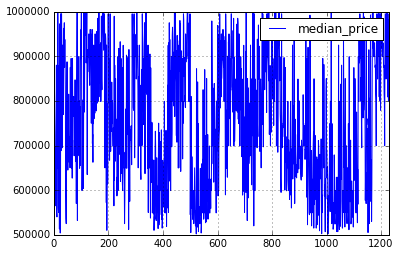